In [4]:
from sklearn.svm import SVC
import nltk
from nltk.corpus.reader import ConllCorpusReader

train = ConllCorpusReader('CoNLL-2003', 'eng.train', ['words', 'pos', 'ignore', 'chunk'])
test = ConllCorpusReader('CoNLL-2003', 'eng.testa', ['words', 'pos', 'ignore', 'chunk'])


In [83]:
from collections import defaultdict

def load_gazetteer_dict():
    with open('./gazetteer.txt') as f:
        lines = f.readlines()
        lines = [i[:-1] for i in lines]
        g_dict = defaultdict(set)
        for line in lines:
            tag, word = line.split()[0], (' ').join(line.split()[1:])
            g_dict[tag].add(word) #stores a set of words for each tag
    
    # print ('gazetteer dict sample: ',g_dict.keys())
    return g_dict
g_dict = load_gazetteer_dict()
g_dict.keys()

dict_keys(['LOC', 'MISC', 'ORG', 'PER'])

In [84]:
from sklearn.feature_extraction import DictVectorizer
from sklearn.preprocessing import LabelEncoder
import re
from copy import copy, deepcopy

def word2features(i, wordseq):
    wi = wordseq[i]
    features = defaultdict(lambda : -1)
    assert wordseq[0] == '<START>' and wordseq[-1] == '<STOP>', "<start> and <stop> tags missing"
    if wi == '<START>' or wi == '<STOP>':
        features.update({
            wi: True
        })
        return features
    
    alphabet = list('abcdefghijklmnopqrstuvwxyz')
    bow = dict()
    for char in alphabet:
        bow['$'+char] = 0
    for char in wi.lower():
        if char in alphabet:
            bow['$'+char] += 1

    features.update(bow)

    features.update({
        # 'Wi': wi,
        # 'Wiaslower': wi.lower(),
        'iswialpha': wi.isalpha(),
        'iswititle': wi.istitle(),
        'iswiupper': wi.isupper(),
        'iswilower': wi.islower(),
        'iswidigit': wi.isdigit(),
        'iswinumeric': wi.isnumeric(),
        'Wishape': len(wi),
        'hasspecialchar': len([w for w in wi if w in list('~!@#$%^&*()_+-={}|:"<>?,./;\'[]')]) != 0   #re.findall('[~!@#$%^&*(){}|:"<>?,./;\'\[\]]', wi) != None,
    })
    if i>1:
        wiminus1 = wordseq[i-1]
        features.update({
            # 'Wi-1': wiminus1,
            'iswiminus1title': wiminus1.istitle(),
            'iswiminus1upper': wiminus1.isupper(),
            'iswiminus1lower': wiminus1.islower(),
            # 'Wi-1aslower': wiminus1.lower(),
        })
    elif i==1:
        features.update({
            'BOS':True,
            'iswiminus1title': -1,
            'iswiminus1upper': -1,
            'iswiminus1lower': -1,
        })
    if i<len(wordseq)-2:
        wiplus1 = wordseq[i+1]
        features.update({
            # 'Wi+1': wiplus1,
            'iswiplus1title': wiplus1.istitle(),
            'iswiplus1upper': wiplus1.isupper(),
            'iswiplus1lower': wiplus1.islower(),
            # 'Wi+1aslower': wiplus1.lower(),
        })
    elif i==len(wordseq)-2:
        features.update({
            'EOS':True,
            'iswiplus1title': -1,
            'iswiplus1upper': -1,
            'iswiplus1lower': -1,
        })

    features.update({
        "gaz" : -1, "gaz+1" : -1, "gaz-1" : -1, "gaz3" : -1,
        'gaztag-LOC' : -1, 'gaztag-PER' : -1, 'gaztag-ORG' : -1, 'gaztag-MISC' : -1,
        'gaz+1tag-LOC' : -1, 'gaz+1tag-PER' : -1, 'gaz+1tag-ORG' : -1, 'gaz+1tag-MISC' : -1,
        'gaz-1tag-LOC' : -1, 'gaz-1tag-PER' : -1, 'gaz-1tag-ORG' : -1, 'gaz-1tag-MISC' : -1,  
    })

    if wi.isalnum():
        gaz = False
        gazplus1 = False
        gazminus1 = False
        gaz3 = False
        for k in g_dict.keys():
            if any(n in g_dict[k] for n in [wi.upper(), wi.lower(), wi.title()]):
                gaz = True
                features.update({
                    'gaztag-'+str(k): 1,
                })
            if 'wiplus1' in locals() and wi+' '+wiplus1 in g_dict[k]:
                gazplus1 = True
                features.update({
                    'gaz+1tag-'+str(k): 1,
                })
            if 'wiminus1' in locals() and wiminus1+' '+wi in g_dict[k]:
                gazminus1 = True
                features.update({
                    'gaz-1tag-'+str(k): 1,
                })
            if 'wiminus1' in locals()  and 'wiplus1' in locals() and wiminus1+' '+wi+' '+wiplus1 in g_dict[k]:
                gaz3 = True
                features.update({
                    'gaz3tag-'+str(k): 1,
                })
        features.update({'gaz': gaz , 'gaz+1': gazplus1 , 'gaz-1': gazminus1 , 'gaz3': gaz3})

    return features

def sent2features(sentence):
    assert isinstance(sentence, list) and isinstance(sentence[0], str), '`sentence` should be list of words as str'
    xs = [None]*len(sentence)
    for i in range(len(sentence)):
        xs[i] = word2features(i, sentence)
    return xs

red2v = DictVectorizer(sparse=False)
def feats2vects(features, test=False):
    if not test:
        tX = red2v.fit_transform(features)
    elif test:
        assert 'red2v' in globals() , 'no fit done earlier for dict to vect'
        tX = red2v.transform(features)
    return tX

def encode_ylabel(y):
    ty = [1 if label.startswith('B-') or label.startswith('I-') else 0 for label in y]
    return ty

In [85]:
import numpy as np
from itertools import chain
def iob_sents2Xy(iob_sents, test=False) :
    sents_list = [['<START>']+[w for w, _, _ in wseq]+['<STOP>'] for wseq in iob_sents]
    s2fs = list(map(sent2features, sents_list))
    Xs = list(chain.from_iterable(s2fs))
    y = list(chain.from_iterable([['<START>']+[e for _, _, e in wseq]+['<STOP>'] for wseq in iob_sents]))
    y = encode_ylabel(y)
    X = feats2vects(Xs, test=test)
    return np.array(X), np.array(y)

In [143]:
m = 500
Xtrain, ytrain = iob_sents2Xy(train.iob_sents()[:m])
Xtrain.shape, ytrain.shape

((7718, 61), (7718,))

# Single

In [171]:
svmclassifier = SVC(probability=True)

svmclassifier.fit(Xtrain,ytrain)

Xtest, ytest = iob_sents2Xy(train.iob_sents()[m:m+10], test=True)

predictions = svmclassifier.predict(Xtest)

print(f'{(predictions == ytest).sum()} correct out of {ytest.shape[0]} entities. '
      f'Accuracy = {(predictions == ytest).sum()/ytest.shape[0]}')
print(predictions[:10], ytest[:10])

187 correct out of 195 entities. Accuracy = 0.958974358974359
[0 0 0 0 0 0 0 0 0 0] [0 0 0 1 0 0 1 0 0 0]


In [ ]:
user_sent = "Ludwig van Beethoven: G.O.A.T from \"Germany\" (1800s AD)."
# user_sent = "Sam"
# s_l = user_sent.split()
pattern = r'(\s|"|:|,|:|;|\'|!|\?|\(|\)|\.$)'
s_l = list(filter(lambda x : ('').__ne__(x) and (' ').__ne__(x), re.split(pattern , user_sent)))
if s_l[-1] != '.':
    s_l.append('.')
s_l = ['<START>'] + s_l + ['<STOP>']
s2f = sent2features(s_l)
x = feats2vects(s2f, test=True)
user_nei = svmclassifier.predict(x)
for w , e in zip(s_l, user_nei):
    print(f"{w:20s} - {e if e==1 else ''}")


# viterbi

In [249]:
svmclassifier.predict_proba(x)

array([[0.97494322, 0.02505678],
       [0.02490268, 0.97509732],
       [0.96505666, 0.03494334],
       [0.0210292 , 0.9789708 ],
       [0.98799203, 0.01200797],
       [0.99863349, 0.00136651],
       [0.05630069, 0.94369931],
       [0.9845131 , 0.0154869 ],
       [0.20087021, 0.79912979],
       [0.98668858, 0.01331142],
       [0.97496493, 0.02503507]])

# Metrics

In [ ]:
from NER import feats2vects, sent2features, svmclassifier, my_token_preps, iob_sents2Xy

testb = ConllCorpusReader('CoNLL-2003', 'eng.testb', ['words', 'pos', 'ignore', 'chunk'])
all_test_sents = testb.iob_sents()
ts = len(all_test_sents)

Xtest, ytest, propsts = iob_sents2Xy(all_test_sents, test=True)
predictions = svmclassifier.predict(Xtest)


Classification Report:

              precision    recall  f1-score   support

        name       0.85      0.92      0.89      8112
     no_name       0.99      0.97      0.98     45691

    accuracy                           0.96     53803
   macro avg       0.92      0.95      0.93     53803
weighted avg       0.97      0.96      0.97     53803



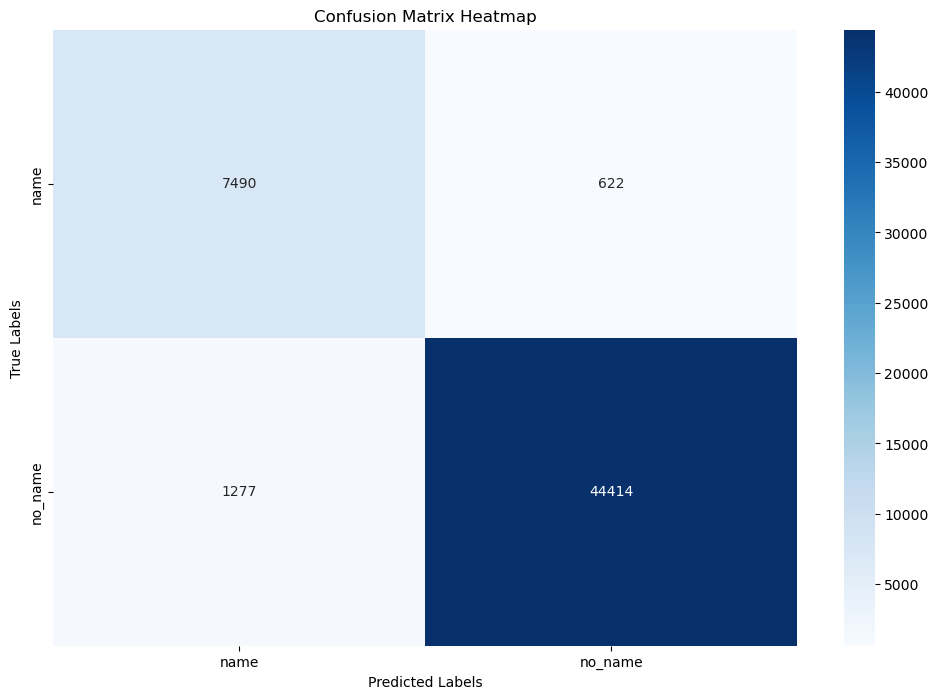

In [11]:

import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix, classification_report, precision_recall_fscore_support
import numpy as np

ytest = ['name' if n==1 else 'no_name' for n in ytest]
predictions = ['name' if n==1 else 'no_name' for n in predictions]

# Calculate confusion matrix
labels = sorted(set(ytest))  # Get all unique labels from ytest
cm = confusion_matrix(ytest, predictions, labels=labels)

# Print precision, recall, and F1 score report
print("Classification Report:\n")
print(classification_report(ytest, predictions, target_names=labels))

# Get precision, recall, and f1-score separately
precision, recall, fscore, _ = precision_recall_fscore_support(ytest, predictions, average=None, labels=labels)

# Plotting the heatmap of confusion matrix
plt.figure(figsize=(12, 8))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", xticklabels=labels, yticklabels=labels)
plt.title("Confusion Matrix Heatmap")
plt.xlabel("Predicted Labels")
plt.ylabel("True Labels")
plt.show()